In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm

# QSample

In [2]:
k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):

    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False
    
meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=True)

fmx_1 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,3)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,5)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

fmx_2 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,0)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

fmx_3 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,1)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,5)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

nfs = qs.Circuit([  {"init": {7,8,9}},
                    {"H": {7,8,9}},
                    {"CNOT": {(7,3)}},
                    {"CNOT": {(7,4)}},
                    {"CNOT": {(7,5)}},
                    {"CNOT": {(7,6)}},
                    {"CNOT": {(8,0)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,6)}},
                    {"CNOT": {(9,1)}},
                    {"CNOT": {(9,2)}},
                    {"CNOT": {(9,5)}},
                    {"CNOT": {(9,6)}},
                    {"H": {7,8,9}},
                    {"measure": {7,8,9}},
                    {"init": {7,8,9}},
                    {"CNOT": {(3,7)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(5,7)}},
                    {"CNOT": {(6,7)}},
                    {"CNOT": {(0,8)}},
                    {"CNOT": {(2,8)}},
                    {"CNOT": {(4,8)}},
                    {"CNOT": {(6,8)}},
                    {"CNOT": {(1,9)}},
                    {"CNOT": {(2,9)}},
                    {"CNOT": {(5,9)}},
                    {"CNOT": {(6,9)}},
                    {"measure": {7,8,9}} ])

# transitions

def flagged(m):
    v = [0b01] in m or [0b11] in m if m is not None else False
    return v

def flut(m, f1a, f1b, f2a, f2b, f3a, f3b):
    formatter = lambda i,m: str(format(m, '06b')[i])

    sx = ''.join([formatter(i,m) for i in range(3)])
    sz = ''.join([formatter(i,m) for i in range(3,6)])

    if (sz == '001' and flagged([f2a,f2b])) or (sz == '010' and (flagged([f1a,f1b]) or flagged([f3a,f3b]))):
        corrs = {'010': {5, 6}, '001': {4, 6}}
        return qs.Circuit([{'X': corrs[sz]}], noisy=False)
    else: 
        return qs.Circuit([{}], noisy=False)

def rep_check(m):
    # no flag triggered, run second round regardless of syndrome
    return m[-1] == 0b00 or m[-1] == 0b10

def nft_check1(m):
    # flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
    return (m[-1] == 0b01 or m[-1] == 0b11 or (m[-1] == 0b01) or m[-1] == 0b11)

def nft_check2(m1,m2):
    return (m2[-1] == 0b00 and m1[-1] == 0b10) or (m2[-1] == 0b10 and m1[-1] == 0b00) or (m2[-1] == 0b01 or m2[-1] == 0b11)

def syn_check(m1,m2):
    # no flag triggered, syndromes agree in second round
    return (m2[-1] == 0b00 and m1[-1] == 0b00) or (m2[-1] == 0b10 and m1[-1] == 0b10)

functions = {"logErr": logErr, "flut": flut, "rep_check": rep_check, "nft_check1": nft_check1, 'nft_check2': nft_check2, "syn_check": syn_check}

# Define protocol

flagstab = qs.Protocol(check_functions=functions, fault_tolerant=True)
flagstab.add_nodes_from(['X1a', 'X1b', 'X2a', 'X2b', 'X3a', 'X3b', 'nonFT', 'meas'], circuits=[fmx_1, fmx_1, fmx_2,fmx_2, fmx_3,fmx_3, nfs, meas7])
flagstab.add_node('COR')
flagstab.add_edge('START', 'X1a', check='True')

# no flag triggered, run second round regardless of syndrome
flagstab.add_edge('X1a', 'X2a', check='rep_check(X1a)')
flagstab.add_edge('X2a', 'X3a', check='rep_check(X2a)')
flagstab.add_edge('X3a', 'X1b', check='rep_check(X3a)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
flagstab.add_edge('X1b', 'nonFT', check='nft_check2(X1a,X1b)')
flagstab.add_edge('X2b', 'nonFT', check='nft_check2(X2a,X2b)')
flagstab.add_edge('X3b', 'nonFT', check='nft_check2(X3a,X3b)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
flagstab.add_edge('X1a', 'nonFT', check='nft_check1(X1a)')
flagstab.add_edge('X2a', 'nonFT', check='nft_check1(X2a)')
flagstab.add_edge('X3a', 'nonFT', check='nft_check1(X3a)')

# no flag triggered, syndromes agree in second round
flagstab.add_edge('X1b', 'X2b', check='syn_check(X1a,X1b)')
flagstab.add_edge('X2b', 'X3b', check='syn_check(X2a,X2b)')
flagstab.add_edge('X3b', 'meas', check='syn_check(X3a,X3b)')

# apply flag correction after nonFT if a flag was triggered
flagstab.add_edge('nonFT', 'COR', check='flut(nonFT[-1], X1a,X1b, X2a,X2b, X3a,X3b)')
flagstab.add_edge('COR', 'meas', check='True')
flagstab.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

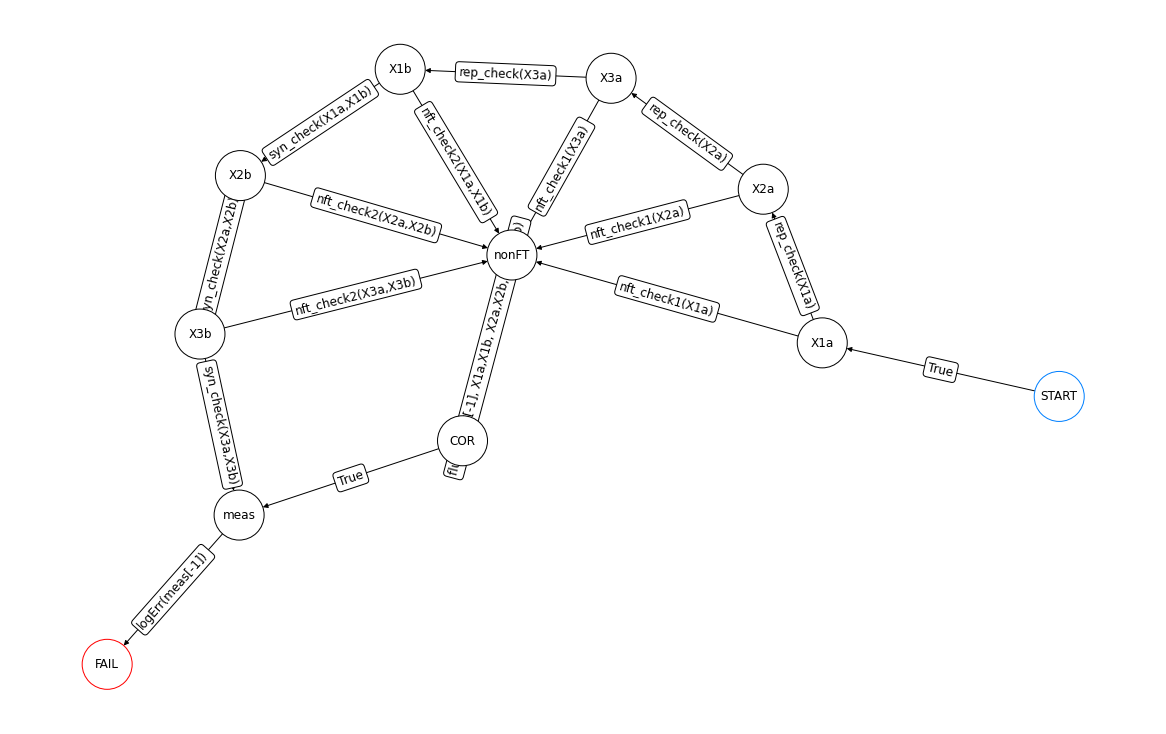

In [3]:
flagstab.draw(figsize=(16,10))

In [4]:
err_model = qs.noise.E1
q_err = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
err_params = {'q': q_err}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=flagstab, simulator=qs.StabilizerSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(2000)
end = time.time()
qsample_time = end-begin

v1 = ss_sam.stats()[0]
w1 = ss_sam.stats()[2]

p=('1.00e-02',):   0%|          | 0/2000 [00:00<?, ?it/s]

## STIM

In [5]:
k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):

    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False
    
meas7 = qs.StimCircuit("""M 0
                        TICK 
                        M 1
                        TICK 
                        M 2
                        TICK 
                        M 3
                        TICK 
                        M 4
                        TICK 
                        M 5
                        TICK 
                        M 6""", noisy=True)

fmx_1 = qs.StimCircuit("""H 8
                        CNOT 8 3
                        TICK
                        CNOT 8 9 
                        TICK
                        CNOT 8 4
                        TICK
                        CNOT 8 5
                        TICK
                        CNOT 8 9
                        TICK
                        CNOT 8 6
                        H 8
                        MR 8 9""")


fmx_2 = qs.StimCircuit("""H 8
                        CNOT 8 0
                        TICK
                        CNOT 8 9
                        TICK
                        CNOT 8 2
                        TICK
                        CNOT 8 4
                        TICK
                        CNOT 8 9
                        TICK
                        CNOT 8 6
                        H 8
                        MR 8 9""")


fmx_3 = qs.StimCircuit("""H 8
                        CNOT 8 1
                        TICK
                        CNOT  8 9
                        TICK
                        CNOT  8 2
                        TICK
                        CNOT  8 5
                        TICK
                        CNOT  8 9
                        TICK
                        CNOT  8 6
                        H 8
                        MR 8 9""")


nfs = qs.StimCircuit("""H 7
                        TICK 
                        H 8
                        TICK 
                        H 9
                    CNOT 7 3
                        TICK
                        CNOT  7 4
                        TICK
                        CNOT  7 5
                        TICK
                        CNOT  7 6
                        TICK
                        CNOT  8 0
                        TICK
                        CNOT  8 2
                        TICK
                        CNOT  8 4
                        TICK
                        CNOT  8 6
                        TICK
                        CNOT  9 1
                        TICK
                        CNOT  9 2
                        TICK
                        CNOT  9 5
                        TICK
                        CNOT  9 6
                    H 7
                        TICK 
                        H 8
                        TICK 
                        H 9
                    MR 7
                        TICK 
                        MR 8
                        TICK 
                        MR 9
                    CNOT 3 7
                        TICK
                        CNOT  4 7
                        TICK
                        CNOT  5 7
                        TICK
                        CNOT  6 7
                        TICK
                        CNOT  0 8
                        TICK
                        CNOT  2 8
                        TICK
                        CNOT  4 8
                        TICK
                        CNOT  6 8
                        TICK
                        CNOT  1 9
                        TICK
                        CNOT  2 9
                        TICK
                        CNOT  5 9
                        TICK
                        CNOT  6 9
                    MR 7
                        TICK 
                        MR 8
                        TICK 
                        MR 9""")


# transitions

def flagged(m):
    v = [0b01] in m or [0b11] in m if m is not None else False
    return v

def flut(m, f1a, f1b, f2a, f2b, f3a, f3b):
    formatter = lambda i,m: str(format(m, '06b')[i])

    sx = ''.join([formatter(i,m) for i in range(3)])
    sz = ''.join([formatter(i,m) for i in range(3,6)])

    if (sz == '001' and flagged([f2a,f2b])) or (sz == '010' and (flagged([f1a,f1b]) or flagged([f3a,f3b]))):
        corrs = {'010': {5, 6}, '001': {4, 6}}
        return qs.StimCircuit("""X {} {}""".format(corrs[sz][0], corrs[sz][1]), noisy=False)
    else: 
        return qs.StimCircuit(noisy=False)

def rep_check(m):
    # no flag triggered, run second round regardless of syndrome
    return m[-1] == 0b00 or m[-1] == 0b10

def nft_check1(m):
    # flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
    return (m[-1] == 0b01 or m[-1] == 0b11 or (m[-1] == 0b01) or m[-1] == 0b11)

def nft_check2(m1,m2):
    return (m2[-1] == 0b00 and m1[-1] == 0b10) or (m2[-1] == 0b10 and m1[-1] == 0b00) or (m2[-1] == 0b01 or m2[-1] == 0b11)

def syn_check(m1,m2):
    # no flag triggered, syndromes agree in second round
    return (m2[-1] == 0b00 and m1[-1] == 0b00) or (m2[-1] == 0b10 and m1[-1] == 0b10)

functions = {"logErr": logErr, "flut": flut, "rep_check": rep_check, "nft_check1": nft_check1, 'nft_check2': nft_check2, "syn_check": syn_check}

# Define protocol

flagstab = qs.Protocol(check_functions=functions, fault_tolerant=True)
flagstab.add_nodes_from(['X1a', 'X1b', 'X2a', 'X2b', 'X3a', 'X3b', 'nonFT', 'meas'], circuits=[fmx_1, fmx_1, fmx_2,fmx_2, fmx_3,fmx_3, nfs, meas7])
flagstab.add_node('COR')
flagstab.add_edge('START', 'X1a', check='True')

# no flag triggered, run second round regardless of syndrome
flagstab.add_edge('X1a', 'X2a', check='rep_check(X1a)')
flagstab.add_edge('X2a', 'X3a', check='rep_check(X2a)')
flagstab.add_edge('X3a', 'X1b', check='rep_check(X3a)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
flagstab.add_edge('X1b', 'nonFT', check='nft_check2(X1a,X1b)')
flagstab.add_edge('X2b', 'nonFT', check='nft_check2(X2a,X2b)')
flagstab.add_edge('X3b', 'nonFT', check='nft_check2(X3a,X3b)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
flagstab.add_edge('X1a', 'nonFT', check='nft_check1(X1a)')
flagstab.add_edge('X2a', 'nonFT', check='nft_check1(X2a)')
flagstab.add_edge('X3a', 'nonFT', check='nft_check1(X3a)')

# no flag triggered, syndromes agree in second round
flagstab.add_edge('X1b', 'X2b', check='syn_check(X1a,X1b)')
flagstab.add_edge('X2b', 'X3b', check='syn_check(X2a,X2b)')
flagstab.add_edge('X3b', 'meas', check='syn_check(X3a,X3b)')

# apply flag correction after nonFT if a flag was triggered
flagstab.add_edge('nonFT', 'COR', check='flut(nonFT[-1], X1a,X1b, X2a,X2b, X3a,X3b)')
flagstab.add_edge('COR', 'meas', check='True')
flagstab.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

In [6]:
err_model = qs.noise.E1
q_err = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
err_params = {'q': q_err}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=flagstab, simulator=qs.StabilizerSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(2000)
end = time.time()
stim_time = end-begin

v2 = ss_sam.stats()[0]
w2 = ss_sam.stats()[2]

p=('1.00e-02',):   0%|          | 0/2000 [00:00<?, ?it/s]

5.902492046356201
5.674844980239868


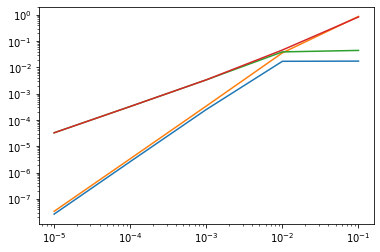

In [7]:
plt.plot(q_err, v1)
plt.plot(q_err, w1)
plt.plot(q_err, v2)
plt.plot(q_err, w2)
plt.xscale('log')
plt.yscale('log')

print(qsample_time)
print(stim_time)